In [ ]:
!pip install alive_progress
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from alive_progress import alive_bar

In [ ]:
base = keras.applications.VGG16(include_top=False, input_shape=(512, 512, 3))
base.trainable = False

In [ ]:
content_layers = ["block3_pool"]
style_layers = ["block1_conv1",
                "block2_conv1",
                "block3_conv1",
                "block4_conv1"]

In [ ]:
IMG_SIZE = (512, 512)
TENSOR_IMG_SHAPE = (1, 512, 512, 3)

content_path = "/content/an.jpeg"
style_path = "/content/anime.jpeg"

content_img = keras.utils.load_img(content_path)
content_img = content_img.resize(IMG_SIZE)
content_numpy = keras.utils.img_to_array(content_img)
content_tensor = keras.applications.vgg16.preprocess_input(content_numpy)

style_img = keras.utils.load_img(style_path)
style_img = style_img.resize(IMG_SIZE)
style_numpy = keras.utils.img_to_array(style_img)
style_tensor = keras.applications.vgg16.preprocess_input(style_numpy)

In [ ]:
def layer_outputs(layers):
    output_layers = [base.get_layer(layer_name).output for layer_name in layers]
    return keras.Model([base.input], output_layers)

In [ ]:
def squared_frobenius_norm(x, y):
    squared_fro_norm = tf.square(x - y)
    squared_fro_norm = tf.reduce_sum(squared_fro_norm)
    return squared_fro_norm

In [ ]:
def content_loss(pred, target):
    return squared_frobenius_norm(pred, target) / 2

In [ ]:
def gram_matrix(activation_map):
    num_channels = activation_map.shape[-1]
    vector = tf.reshape(activation_map, (-1, num_channels))
    return tf.matmul(vector, vector, transpose_a=True)

In [ ]:
def style_loss(g_styles, s_styles, weights=None):
    loss = 0
    g_gram_matrices = [gram_matrix(g_style) for g_style in g_styles]
    s_gram_matrices = [gram_matrix(s_style) for s_style in s_styles]
    if weights:
        for g_gram, s_gram, weight in zip(g_gram_matrices, s_gram_matrices, weights):
            loss += weights[i] * squared_frobenius_norm(g_gram_matrices[i],
                                                        s_gram_matrices[i]) / 2
    else:
        for g_gram, s_gram in zip(g_gram_matrices, s_gram_matrices):
            loss += squared_frobenius_norm(g_gram, s_gram) / 2
    return loss

In [ ]:
def deprocess_image(img, data_format='channels_last'):
    mean = [103.939, 116.779, 123.68]
    x = np.array(img)
    if data_format == 'channels_first':
        if x.ndim == 3:
            x[0, :, :] += mean[0]
            x[1, :, :] += mean[1]
            x[2, :, :] += mean[2]
        else:
            x[:, 0, :, :] += mean[0]
            x[:, 1, :, :] += mean[1]
            x[:, 2, :, :] += mean[2]
    else:
        x[..., 0] += mean[0]
        x[..., 1] += mean[1]
        x[..., 2] += mean[2]

    if data_format == 'channels_first':
        # 'BGR'->'RGB'
        if x.ndim == 3:
            x = x[::-1, ...]
        else:
            x = x[:, ::-1, ...]
    else:
        # 'BGR'->'RGB'
        x = x[..., ::-1]

    return x[0]

In [ ]:
EPOCHS = 500
LEARNING_RATE = 1e-2
ALPHA = 6e-3
BETA = 5e-14
DISPLAY_STEP = 100

on 99: Epoch 100: content loss = 1420877952.0


on 99: WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


|███████▉                                | ▃▅▇ 99/500 [20%] in 20s (5.1/s, eta: 1:17) 

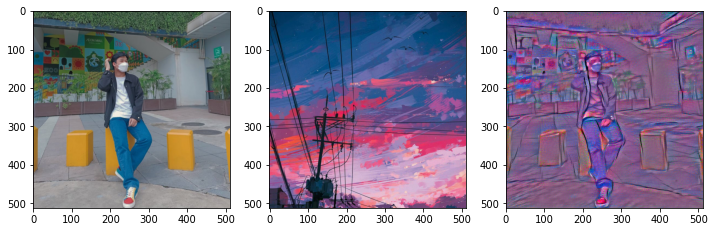

on 199: Epoch 200: content loss = 1076768384.0


on 199: WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


|███████████████▉                        | █▆▄ 199/500 [40%] in 40s (5.0/s, eta: 59s) 

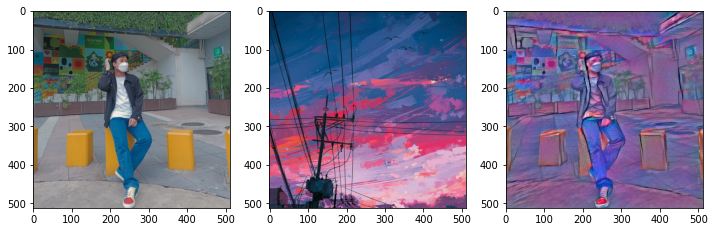

on 299: Epoch 300: content loss = 955447808.0


on 299: WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


|███████████████████████▉                | ▃▁▃ 299/500 [60%] in 1:00 (5.0/s, eta: 40s) 

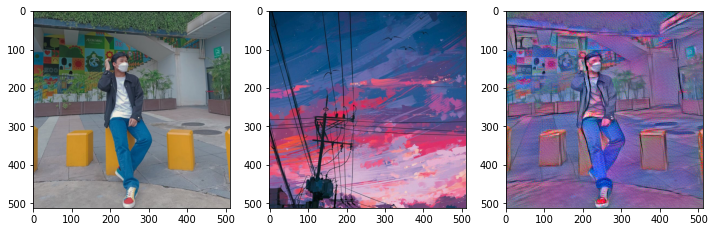

on 399: Epoch 400: content loss = 619220608.0


on 399: WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


|███████████████████████████████▉        | ▂▄▆ 399/500 [80%] in 1:19 (5.0/s, eta: 20s) 

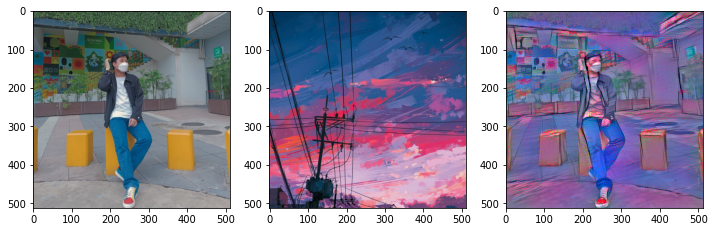

on 499: Epoch 500: content loss = 868844416.0


on 499: WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


|███████████████████████████████████████▉| ▅▇▇ 499/500 [100%] in 1:39 (5.0/s, eta: 0s) 

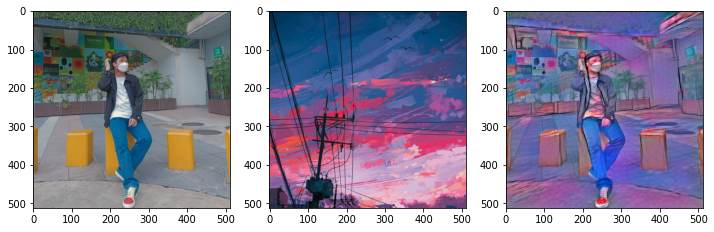

|████████████████████████████████████████| 500/500 [100%] in 1:39.6 (5.02/s)                                            


In [ ]:
content_extractor = layer_outputs(content_layers)
style_extractor = layer_outputs(style_layers)

content_tensor = tf.reshape(content_tensor, TENSOR_IMG_SHAPE)
style_tensor = tf.reshape(style_tensor, TENSOR_IMG_SHAPE)

generated_tensor = tf.random.uniform(TENSOR_IMG_SHAPE, -1, 1)
generated_tensor = tf.Variable(generated_tensor, trainable=True)

c_content = content_extractor(content_tensor)
s_styles = style_extractor(style_tensor)

C = deprocess_image(content_tensor)
S = deprocess_image(style_tensor)

with alive_bar(EPOCHS, force_tty=True) as bar:
    for i in range(EPOCHS):   
        with tf.GradientTape() as tape:
            tape.watch(generated_tensor)
            g_content = content_extractor(generated_tensor)
            g_styles = style_extractor(generated_tensor)

            assert len(g_styles) == len(s_styles)

            loss_content = content_loss(c_content, g_content)
            loss_style = style_loss(s_styles, g_styles)
            loss = ALPHA * loss_content + BETA * loss_style

        grads = tape.gradient(loss, generated_tensor)
        _ = generated_tensor.assign_sub(LEARNING_RATE * grads)
        G = deprocess_image(generated_tensor)

        if (i + 1) % DISPLAY_STEP == 0:
            print("Epoch {}: content loss = {}".format(i+1, loss))
            fig = plt.figure(3, figsize=(12, 4))
            fig.add_subplot(1, 3, 1)
            plt.imshow(C/255.)
            fig.add_subplot(1, 3, 2)
            plt.imshow(S/255.)
            fig.add_subplot(1, 3, 3)
            plt.imshow(G/255.)
            plt.show()

        bar()

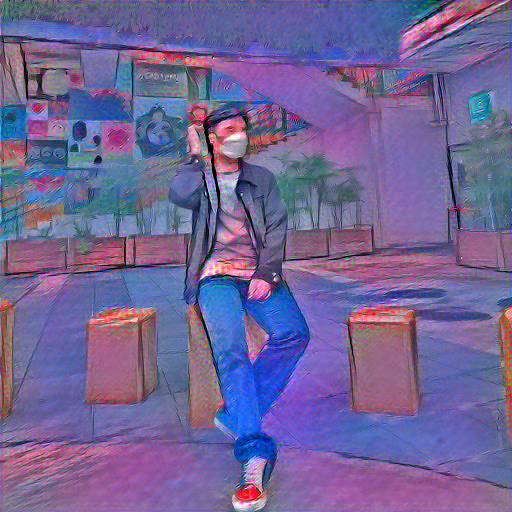

In [ ]:
# Save image
keras.utils.array_to_img(tf.minimum(tf.maximum(0, G), 255))